### Accelerating Ocean Climate Modeling with Intel Gaudi's MME

#### Background: Why Ocean Modeling Matters

Ocean modeling is a critical component of climate science and Earth system modeling. The **Model for Prediction Across Scales - Ocean (MPAS-Ocean)** is used by the U.S. Department of Energy's Energy Exascale Earth System Model (E3SM) to simulate the full three-dimensional circulation of the ocean. These simulations help us understand:

- Climate change and its effects on ocean currents
- Heat distribution across the planet
- Marine ecosystem dynamics
- Sea level rise predictions

#### The Computational Challenge

One of the most computationally expensive operations in MPAS-Ocean is **tracer advection** - the transport of quantities like temperature, salinity, and chemical concentrations by ocean currents. This operation must be computed millions of times in a typical climate simulation, making it a prime target for optimization.

#### TensorOcean: Bridging Ocean Modeling and AI Hardware

Researchers at Los Alamos National Laboratory developed **TensorOcean** ([Tang et al., 2023](https://doi.org/10.1145/3587278.3595645)) to explore whether AI-optimized accelerators could be repurposed for scientific computing. Their key insight was:

> **If we can express ocean modeling operations as tensor operations, we can leverage specialized AI hardware designed for matrix multiplication.**

The original TensorOcean implementation used **boolean masking** to select neighboring cells in the hexagonal ocean mesh - a natural approach in PyTorch but not optimized the Gaudi architecture.

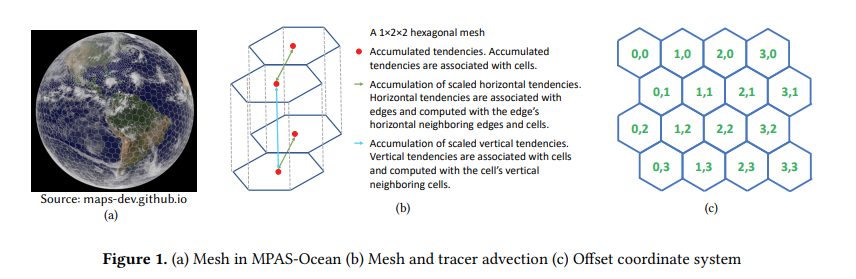

#### Our Optimization: Leveraging Gaudi's MME

Intel Gaudi processors feature specialized **Matrix Multiplication Engines (MMEs)** designed for AI workloads. In this notebook, we demonstrate how converting boolean mask operations to matrix multiplications can dramatically accelerate ocean tracer advection on Gaudi hardware.

 **Original approach (TensorOcean):**
 ```python
# Boolean indexing - flexible but not MME-optimized
selected_cells = all_cells[:, :, :, boolean_mask]
 ```

 **Our approach (Gaudi-optimized):**
 ```python
# Matrix multiplication - leverages MME hardware
selected_cells = torch.matmul(all_cells.reshape(-1, N), selection_matrix.T)
 ```

- In a large simulation, the tracer advection opertion could be called many times per simulation. The selection matrices can be pre-computed once and reused.
- This means the overhead of creating selection matrices is amortized across the entire simulation, while the MME acceleration benefits apply to every tracer advection call.

#### Note
- We do acknowledge that Gaudi supports up to FP32 and that climate modeling is done in FP64
- The LANL researchers do mention in their paper that they are using single precision.
> All the physics data values are single-precision floating-point numbers

In [1]:
# HPU TensorOcean Implementation with Gaudi MME Performance Demo

import torch
import time 
import habana_frameworks.torch.core as htcore

# Configuration
N = 500  # Mesh length (adjust as needed)
L = 500   # Mesh depth (adjust as needed)
T = 1   # Number of tracers (adjust as needed)
dtype_str = "float32"
seed = 42

# Setup dtype
dtype_map = {
    "float32": torch.float32,
    "float16": torch.float16, 
    "bfloat16": torch.bfloat16
}
torch.set_default_dtype(dtype_map[dtype_str])
torch.manual_seed(seed)

M = N + 4  # Mesh length with halo cells

print(f"Mesh size: {N}x{N}x{L} ({N*N*L:,} total cells)")
print(f"Number of tracers: {T}")
print(f"Data type: {dtype_str} ({torch.get_default_dtype()})")
print(f"Random seed: {seed} (for reproducibility)")

device = torch.device("hpu")
print(f"\nHardware: {device}")

Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)


Mesh size: 500×500×500 (125,000,000 total cells)
Number of tracers: 1
Data type: float32 (torch.float32)
Random seed: 42 (for reproducibility)

Hardware: hpu


#### Step 1: Initialize Ocean Mesh and Physics Data

In MPAS-Ocean, the mesh consists of:
 - **Cells**: Where tracer values (temperature, salinity, etc.) are stored
 - **Edges**: Where fluxes (transport rates) are computed
 - **Connectivity**: Which cells neighbor which edges

#### For this demo, we create synthetic data that represents these mesh quantities.

In [2]:
print("\n" + "="*70)
print("STEP 1: Creating Ocean Mesh Data")
print("="*70)
print("Creating deterministic tensors on CPU, then moving to HPU...")
print("(In production, this data would come from MPAS-Ocean mesh files)")

# Create all tensors on CPU first with deterministic seeding
torch.manual_seed(seed)

# Edge and cell connectivity data
edgeSignOnCell1_cpu      = torch.randn(1,N+1,N*2+1)
edgeSignOnCell2_cpu      = torch.randn(1,N,N+1)
areaCell_cpu             = torch.randn(N)

# Advection scheme coefficients
coef3rdOrder             = 0.250
dvEdge1_cpu              = torch.randn(1,N+1,N*2+1,1)
dvEdge2_cpu              = torch.randn(1,N,N+1,1)
advMaskHighOrder1_cpu    = torch.randn(L,N+1,N*2+1,1)
advMaskHighOrder2_cpu    = torch.randn(L,N,N+1,1)
advCoefs1_cpu            = torch.randn(1,N+1,N*2+1,10)
advCoefs2_cpu            = torch.randn(1,N,N+1,10)
advCoefs3rd1_cpu         = torch.randn(1,N+1,N*2+1,10)
advCoefs3rd2_cpu         = torch.randn(1,N,N+1,10)

# Flux and tracer data
normalThicknessFlux1_cpu = torch.randn(L,N+1,N*2+1,1)
normalThicknessFlux2_cpu = torch.randn(L,N,N+1,1)
cell_cpu                 = torch.randn(L,M,M)  # Tracer values at cell centers

print(f"Created {14} mesh and physics tensors on CPU")
print(f"   This might take a couple of seconds.")
print(f"Total data size: ~{(cell_cpu.numel() * 4 / 1e9):.2f} GB")

# Move all tensors to HPU
print(f"\n Moving tensors to HPU...")
edgeSignOnCell1      = edgeSignOnCell1_cpu.to(device)
edgeSignOnCell2      = edgeSignOnCell2_cpu.to(device)
areaCell             = areaCell_cpu.to(device)
dvEdge1              = dvEdge1_cpu.to(device)
dvEdge2              = dvEdge2_cpu.to(device)
advMaskHighOrder1    = advMaskHighOrder1_cpu.to(device)
advMaskHighOrder2    = advMaskHighOrder2_cpu.to(device)
advCoefs1            = advCoefs1_cpu.to(device)
advCoefs2            = advCoefs2_cpu.to(device)
advCoefs3rd1         = advCoefs3rd1_cpu.to(device)
advCoefs3rd2         = advCoefs3rd2_cpu.to(device)
normalThicknessFlux1 = normalThicknessFlux1_cpu.to(device)
normalThicknessFlux2 = normalThicknessFlux2_cpu.to(device)
cell                 = cell_cpu.to(device)

print(f"All data successfully transferred to HPU")


STEP 1: Creating Ocean Mesh Data
Creating deterministic tensors on CPU, then moving to HPU...
(In production, this data would come from MPAS-Ocean mesh files)
Created 14 mesh and physics tensors on CPU
   This might take a couple of seconds.
Total data size: ~0.51 GB

 Moving tensors to HPU...


============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 ============= 
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------


All data successfully transferred to HPU


#### Step 2: Create Selection Matrices (One-Time Setup)

In the original TensorOcean implementation, boolean masks were used to select neighboring cells:
```python
# Original: Boolean indexing (not MME-optimized)
EvenRow2_cells = b[:, ::2, :, boolean_mask]  # Scattered memory access
```

#### We convert these boolean masks into **selection matrices** that can be used with matrix multiplication:
```python
# Optimized: Matrix multiplication (leverages MME)
EvenRow2_cells = torch.matmul(b.reshape(-1, 12), selection_matrix.T)  # Fast MME operation
```

- Boolean indexing requires scattered memory reads (slow)
- Matrix multiplication uses contiguous memory and specialized MME hardware (fast)
- Selection matrices are created **once** and reused for the entire simulation

In [3]:
print("\n" + "="*70)
print("STEP 2: Creating MME-Optimized Selection Matrices")
print("="*70)

# Boolean masks (original TensorOcean approach)
EvenRow2_mask_bool = torch.tensor([False,True,True,True,True,True,True,True,False,True,True,True], device=device)
OddRow2_mask_bool = torch.tensor([True,True,True,False,True,True,True,True,True,True,True,False], device=device)
EvenRowEvenCol1_mask_bool = torch.tensor([False,True,True,False,True,True,True,False,False,True,True,True,False,True,True,False], device=device)
EvenRowOddCol1_mask_bool = torch.tensor([False,False,True,True,False,True,True,True,False,True,True,True,False,True,True,False], device=device)
OddRowEvenCol1_mask_bool = torch.tensor([False,True,True,False,False,True,True,True,True,True,True,False,False,True,True,False], device=device)
OddRowOddCol1_mask_bool = torch.tensor([False,True,True,False,False,True,True,True,False,True,True,True,False,False,True,True], device=device)

# Convert to indices
EvenRow2_indices = torch.nonzero(EvenRow2_mask_bool, as_tuple=False).squeeze(-1)
OddRow2_indices = torch.nonzero(OddRow2_mask_bool, as_tuple=False).squeeze(-1)
EvenRowEvenCol1_indices = torch.nonzero(EvenRowEvenCol1_mask_bool, as_tuple=False).squeeze(-1)
EvenRowOddCol1_indices = torch.nonzero(EvenRowOddCol1_mask_bool, as_tuple=False).squeeze(-1)
OddRowEvenCol1_indices = torch.nonzero(OddRowEvenCol1_mask_bool, as_tuple=False).squeeze(-1)
OddRowOddCol1_indices = torch.nonzero(OddRowOddCol1_mask_bool, as_tuple=False).squeeze(-1)

print(f"Extracted indices from boolean masks")

# Create selection matrices for MME operations
EvenRow2_matrix = torch.zeros(len(EvenRow2_indices), 12, device=device)
for i, idx in enumerate(EvenRow2_indices):
    EvenRow2_matrix[i, idx] = 1.0
    
OddRow2_matrix = torch.zeros(len(OddRow2_indices), 12, device=device)
for i, idx in enumerate(OddRow2_indices):
    OddRow2_matrix[i, idx] = 1.0
    
EvenRowEvenCol1_matrix = torch.zeros(len(EvenRowEvenCol1_indices), 16, device=device)
for i, idx in enumerate(EvenRowEvenCol1_indices):
    EvenRowEvenCol1_matrix[i, idx] = 1.0
    
EvenRowOddCol1_matrix = torch.zeros(len(EvenRowOddCol1_indices), 16, device=device)
for i, idx in enumerate(EvenRowOddCol1_indices):
    EvenRowOddCol1_matrix[i, idx] = 1.0
    
OddRowEvenCol1_matrix = torch.zeros(len(OddRowEvenCol1_indices), 16, device=device)
for i, idx in enumerate(OddRowEvenCol1_indices):
    OddRowEvenCol1_matrix[i, idx] = 1.0
    
OddRowOddCol1_matrix = torch.zeros(len(OddRowOddCol1_indices), 16, device=device)
for i, idx in enumerate(OddRowOddCol1_indices):
    OddRowOddCol1_matrix[i, idx] = 1.0

htcore.mark_step()

print(f"Matrix dimensions: {EvenRow2_matrix.shape}, {EvenRowEvenCol1_matrix.shape}, etc.")


STEP 2: Creating MME-Optimized Selection Matrices
Extracted indices from boolean masks
Matrix dimensions: torch.Size([10, 12]), torch.Size([10, 16]), etc.


#### Step 3: Compute Horizontal Fluxes (MME-Accelerated)

We demonstrate the MME acceleration on two sets of operations:

**Operation Set 1:** Computing fluxes for slope edges (12-neighbor stencil)

**Operation Set 2:** Computing fluxes for horizontal edges (16-neighbor stencil)

In each case, we:
1. Create sliding windows over the mesh
2. Use matrix multiplication (MME) to select the correct neighbors
3. Measure the performance in TFLOPS (trillion floating-point operations per second), though it only takes around a millisecond or so for Gaudi to do these matmul operations

In [4]:
print("\n" + "="*70)
print("STEP 3: MME-Accelerated Horizontal Flux Computation")
print("="*70)
print("Computing tracer fluxes using Gaudi's Matrix Multiplication Engine\n")

# Horizontal flux computation timing
t1 = time.perf_counter()

# 3rd order fluxes - Generating sliding windows
a = cell[:,1:cell.size(dim=1)-1,:].unfold(2,4,1)
b = torch.cat((a[:,0:a.size(dim=1)-2,:], a[:,1:a.size(dim=1)-1,:], a[:,2:a.size(dim=1),:]), 3)

print(f"\n[MME Demo 1] First matmul operations:")

# === MME PERFORMANCE DEMO: First set of matmul operations ===
htcore.mark_step()
t_mme1_start = time.perf_counter()

# CRITICAL OPERATION: Matrix multiplication replaces boolean indexing
# Original (slow):  EvenRow2_cells = b[:,::2,:,boolean_mask]
# Optimized (fast): torch.matmul leverages MME hardware
EvenRow2_cells = torch.matmul(b[:,::2,:,:].reshape(-1, 12), EvenRow2_matrix.T).reshape(b.shape[0], b.shape[1]//2, b.shape[2], -1)
OddRow2_cells = torch.matmul(b[:,1::2,:,:].reshape(-1, 12), OddRow2_matrix.T).reshape(b.shape[0], b.shape[1]//2, b.shape[2], -1)

htcore.mark_step()
t_mme1 = time.perf_counter() - t_mme1_start

# Calculate FLOPS for first set
m1, k1, n1 = b[:,::2,:,:].reshape(-1, 12).shape[0], 12, EvenRow2_matrix.T.shape[1]
m2, k2, n2 = b[:,1::2,:,:].reshape(-1, 12).shape[0], 12, OddRow2_matrix.T.shape[1]
flops_mme1 = 2 * (m1 * k1 * n1 + m2 * k2 * n2)
tflops_mme1 = flops_mme1 / t_mme1 / 1e12

print(f"Execution time:      {t_mme1*1000:.3f} ms")
print(f"MME performance:     {tflops_mme1:.3f} TFLOPS")
print(f"Matrix dimensions:   ({m1:,}x{k1}) @ ({k1}x{n1})")
print(f"                        ({m2:,}x{k2}) @ ({k2}x{n2})")
print(f"Data processed:      {(m1*k1 + m2*k2)*4/1e9:.2f} GB input")

# Selecting neighboring cells for horizontal edges
a = cell.unfold(2,4,1)
b = torch.cat((a[:,0:a.size(dim=1)-3,:], a[:,1:a.size(dim=1)-2,:], a[:,2:a.size(dim=1)-1,:], a[:,3:a.size(dim=1),:]), 3)
EvenRow = b[:,::2,:,:]
OddRow  = b[:,1::2,:,:]

print(f"\n[MME Demo 2] Second matmul operations:")

# === MME PERFORMANCE DEMO: Second set of matmul operations ===
htcore.mark_step()
t_mme2_start = time.perf_counter()

# Four separate matrix multiplications for different edge orientations
# Each one leverages the MME for maximum performance
EvenRowEvenCol1_cells = torch.matmul(EvenRow.reshape(-1, 16), EvenRowEvenCol1_matrix.T).reshape(EvenRow.shape[0], EvenRow.shape[1], EvenRow.shape[2], -1)
EvenRowOddCol1_cells = torch.matmul(EvenRow[:,:,:EvenRow.size(dim=2)-1,:].reshape(-1, 16), EvenRowOddCol1_matrix.T).reshape(EvenRow.shape[0], EvenRow.shape[1], EvenRow.shape[2]-1, -1)
OddRowEvenCol1_cells = torch.matmul(OddRow.reshape(-1, 16), OddRowEvenCol1_matrix.T).reshape(OddRow.shape[0], OddRow.shape[1], OddRow.shape[2], -1)
OddRowOddCol1_cells = torch.matmul(OddRow[:,:,:OddRow.size(dim=2)-1,:].reshape(-1, 16), OddRowOddCol1_matrix.T).reshape(OddRow.shape[0], OddRow.shape[1], OddRow.shape[2]-1, -1)

htcore.mark_step()
t_mme2 = time.perf_counter() - t_mme2_start

# Calculate FLOPS for second set
m3, k3, n3 = EvenRow.reshape(-1, 16).shape[0], 16, EvenRowEvenCol1_matrix.T.shape[1]
m4, k4, n4 = EvenRow[:,:,:EvenRow.size(dim=2)-1,:].reshape(-1, 16).shape[0], 16, EvenRowOddCol1_matrix.T.shape[1]
m5, k5, n5 = OddRow.reshape(-1, 16).shape[0], 16, OddRowEvenCol1_matrix.T.shape[1]
m6, k6, n6 = OddRow[:,:,:OddRow.size(dim=2)-1,:].reshape(-1, 16).shape[0], 16, OddRowOddCol1_matrix.T.shape[1]
flops_mme2 = 2 * (m3*k3*n3 + m4*k4*n4 + m5*k5*n5 + m6*k6*n6)
tflops_mme2 = flops_mme2 / t_mme2 / 1e12

print(f"Execution time:      {t_mme2*1000:.3f} ms")
print(f"MME performance:     {tflops_mme2:.3f} TFLOPS")
print(f"Matrix dimensions:   4 operations, each ~({m3:,}x{k3}) @ ({k3}x{n3})")
print(f"Data processed:      {(m3*k3 + m4*k4 + m5*k5 + m6*k6)*4/1e9:.2f} GB input")


STEP 3: MME-Accelerated Horizontal Flux Computation
Computing tracer fluxes using Gaudi's Matrix Multiplication Engine


[MME Demo 1] First matmul operations:
Execution time:      0.695 ms
MME performance:     43.223 TFLOPS
Matrix dimensions:   (62,625,000×12) @ (12×10)
                        (62,625,000×12) @ (12×10)
Data processed:      6.01 GB input

[MME Demo 2] Second matmul operations:
Execution time:      0.642 ms
MME performance:     124.888 TFLOPS
Matrix dimensions:   4 operations, each ~(62,875,500×16) @ (16×10)
Data processed:      16.05 GB input


### The data has further to go to complete the rest of the TensorOcean workflow, but hopefully this gave you an idea of how useful Gaudi's MMEs can be.